1. Theory Questions:
*   Q1: Explain the minimax loss function in GANs and how it ensures training
between the generator and discriminator is competitive.\
The minimax loss function in GANs ensure competitive training as the generator works to minimize the discriminator's ability to distinguish between real and fake images while the discriminator works to maximize the its ability to distinguish between real and fake. The adversarial nature helps to push the GAN to equalibrium.
*   Q2: What is mode collapse, Why can mode collapse occur during GAN training? and how can it be mitigated?\
Mode collapse is when the generator does not provide varied enough outputs and the discriminator learns the pattern. Mode collapse often occurs when the generator is underpowered or the discriminator is over powered, causing imbalance in the adversarial relationship. This can be mitigated through batch normalization, minibatch discrimination, or using a WGAN.
*   Q3: Explain the role of the discriminator in adversarial training?\
The role of the discriminator is to learn to distinguish between the fake and real images/data being created by the generator. Since they are being trained simultaneously a push/pull effect is created.
*   Q4: How do metrics like IS and FID evaluate GAN performance?
Fréchet inception distance is a metric used to evaluate GAN performance based on the distrubution of generated data as compared to the distribution of real images. Essentially this metric measures how close the generated data are to the ground truth data. The Inception score is similar, however it does not conscider the ground truth data and only looks at the generated data. The insception score looks to see how diverse the dataset is. This can be used as an indicator for mode collapse.
2. Coding Assignment:
Implement and Experiment with GANs:
*   Modify the generator to include additional convolutional layers.
*   Implement image saving after every 10 epochs.
*   Replace the MNIST dataset with CIFAR-10 and update the network for the new dimensions.



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import math
import matplotlib.pyplot as plt
# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator model
def make_generator_model():
  model = tf.keras.Sequential([
  layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
  layers.BatchNormalization(),
  layers.LeakyReLU(),
  layers.Reshape((7, 7, 256)),
  layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(),
  layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(),
  layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False),
  layers.LeakyReLU(),
  layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
  return model

# Discriminator model
def make_discriminator_model():
  model = tf.keras.Sequential([
  layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same', input_shape = [28, 28, 1]),
  layers.LeakyReLU(),
  layers.Dropout(0.15),
  layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
  layers.BatchNormalization(),
  layers.LeakyReLU(),
  layers.Dropout(0.15),
  layers.Flatten(),
  layers.Dense(1)
  ])
  return model


# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1 = 0.5)

generated_images_array = []


# Training function
@tf.function
def train_step(images, epoch):
  noise = tf.random.normal([BATCH_SIZE, 100])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    saved_image = None
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  if (epoch + 1) % 10 == 0:
    saved_image = generated_images[0]

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return [gen_loss, disc_loss, saved_image]

gen_loss = []
disc_loss = []

# Training loop
def train(dataset, epochs):
  for epoch in range(epochs):
    g_loss = 0
    d_loss = 0
    for image_batch in dataset:
      g, d, im = train_step(image_batch, epoch)
      g_loss += g
      d_loss += d
      if im is not None:
          generated_images_array.append(im)
    gen_loss.append(g_loss)
    disc_loss.append(d_loss)
    print(f"Epoch: {epoch}   Generator Loss: {g_loss}   Discriminator Loss: {d_loss}")

epochs = 50
# Run the training
train(train_dataset, epochs=epochs)
print("Training Complete")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch: 0   Generator Loss: 117.83596801757812   Discriminator Loss: 453.01959228515625
Epoch: 1   Generator Loss: 153.3780059814453   Discriminator Loss: 380.71173095703125
Epoch: 2   Generator Loss: 165.24569702148438   Discriminator Loss: 355.26666259765625
Epoch: 3   Generator Loss: 172.28944396972656   Discriminator Loss: 340.8502502441406
Epoch: 4   Generator Loss: 174.13783264160156   Discriminator Loss: 336.3060302734375
Epoch: 5   Generator Loss: 178.66177368164062   Discriminator Loss: 327.6114196777344
Epoch: 6   Generator Loss: 180.6986541748047   Discriminator Loss: 323.0293273925781
Epoch: 7   Generator Loss: 182.84829711914062   Discriminator Loss: 317.364013671875
Epoch: 8   Generator Loss: 182.68606567382812   Discriminator Loss: 317.0491027832031
Epoch: 9   Generator Loss: 180.1312255859375   Discriminator Loss: 319.3267822265625
Epoch: 10   Generator Loss: 180.53009033203125   Discriminator Loss: 320.1142883300781
Epoch: 11   Generator Loss: 180.59088134765625   Discr

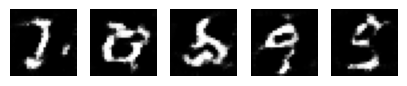

In [ ]:
num_images = math.floor(epochs/10)
fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
if num_images == 1:
  axs = [axs]
for i in range(num_images):
    im = ((generated_images_array[i] * 127.5 ) + 127.5)
    axs[i].imshow(im, cmap = 'gray')
    axs[i].axis('off')
plt.show()

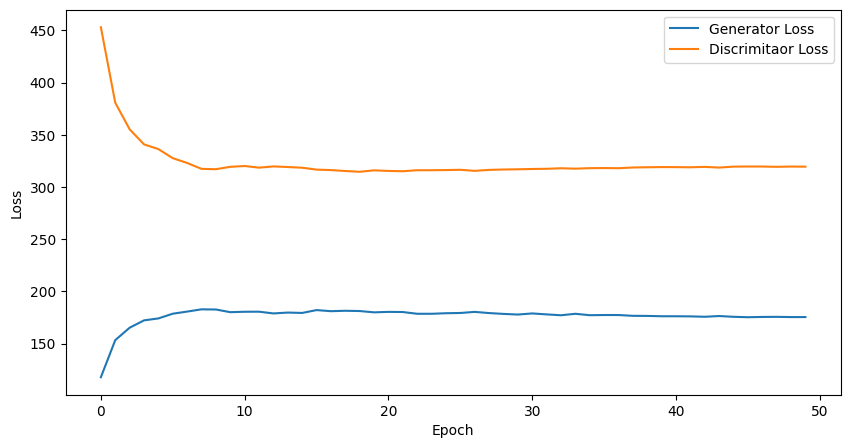

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(gen_loss, label = 'Generator Loss')
plt.plot(disc_loss, label="Discrimitaor Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import math
import matplotlib.pyplot as plt
# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
# train_images = train_images.reshape(-1, 32, 32, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Generator model
def make_generator_model():
  model = tf.keras.Sequential([
  layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
  layers.BatchNormalization(),
  layers.LeakyReLU(),
  layers.Reshape((8, 8, 256)),
  layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(),
  layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(),
  layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False),
  layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
  return model

# Discriminator model
def make_discriminator_model():
  model = tf.keras.Sequential([
  layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same', input_shape = [32, 32, 3]),
  layers.LeakyReLU(),
  layers.Dropout(0.1),
  layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
  layers.BatchNormalization(),
  layers.LeakyReLU(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(1)
  ])
  return model


# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1 = 0.5)

generated_images_array = []


# Training function
@tf.function
def train_step(images, epoch):
  noise = tf.random.normal([BATCH_SIZE, 100])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    saved_image = None
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  if (epoch + 1) % 10 == 0:
    saved_image = generated_images[0]

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return [gen_loss, disc_loss, saved_image]

gen_loss = []
disc_loss = []

# Training loop
def train(dataset, epochs):
  for epoch in range(epochs):
    g_loss = 0
    d_loss = 0
    for image_batch in dataset:
      g, d, im = train_step(image_batch, epoch)
      g_loss += g
      d_loss += d
      if im is not None:
          generated_images_array.append(im)
    gen_loss.append(g_loss)
    disc_loss.append(d_loss)
    print(f"Epoch: {epoch}   Generator Loss: {g_loss}   Discriminator Loss: {d_loss}")

epochs = 100
# Run the training
train(train_dataset, epochs=epochs)
print("Training Complete")

Epoch: 0   Generator Loss: 57.0549201965332   Discriminator Loss: 602.4528198242188
Epoch: 1   Generator Loss: 143.73370361328125   Discriminator Loss: 320.67626953125
Epoch: 2   Generator Loss: 202.90298461914062   Discriminator Loss: 243.5507354736328
Epoch: 3   Generator Loss: 122.56391906738281   Discriminator Loss: 341.4159240722656
Epoch: 4   Generator Loss: 117.77265930175781   Discriminator Loss: 339.7982177734375
Epoch: 5   Generator Loss: 123.68245697021484   Discriminator Loss: 318.8117980957031
Epoch: 6   Generator Loss: 128.10113525390625   Discriminator Loss: 304.9541320800781
Epoch: 7   Generator Loss: 131.0709228515625   Discriminator Loss: 296.644287109375
Epoch: 8   Generator Loss: 137.055908203125   Discriminator Loss: 289.6477355957031
Epoch: 9   Generator Loss: 174.43838500976562   Discriminator Loss: 258.9042663574219
Epoch: 10   Generator Loss: 152.85279846191406   Discriminator Loss: 268.5252380371094
Epoch: 11   Generator Loss: 141.6887664794922   Discriminator

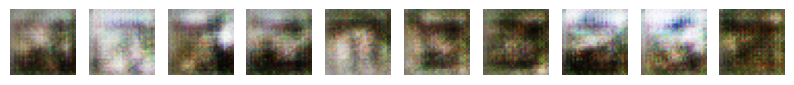

In [ ]:
num_images = math.floor(epochs/10)
fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
if num_images == 1:
  axs = [axs]
for i in range(num_images):
    im = ((generated_images_array[i] + 1 )/2)
    axs[i].imshow(im)
    axs[i].axis('off')
plt.show()

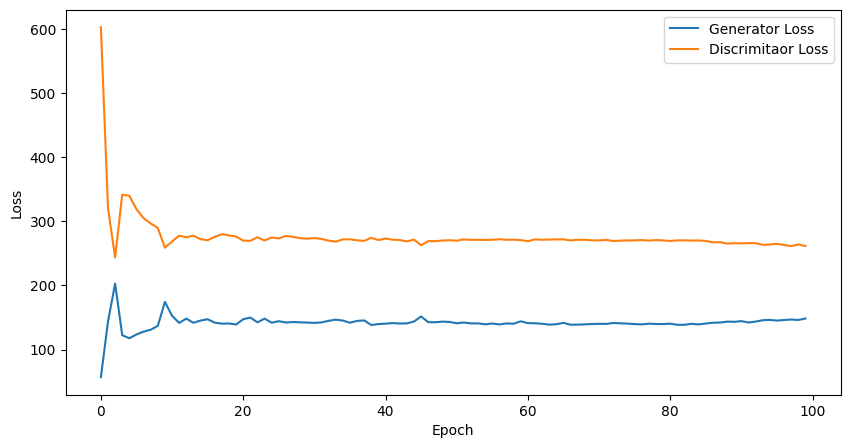

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(gen_loss, label = 'Generator Loss')
plt.plot(disc_loss, label="Discrimitaor Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()